### What is Attention?

Attention mechanisms allow models to focus on relevant parts of the input when generating each part of the output. In sequence-to-sequence tasks like machine translation, attention helps the model decide which words in the input sentence are most relevant to generating the next word in the output sentence.

### Why is Attention Important?

- **Handles Long Dependencies**: Captures relationships between distant elements in sequences.
- **Improves Performance**: Enhances accuracy in tasks like translation, summarization, and question answering.
- **Interpretability**: Provides insights into what the model is focusing on, making it more interpretable.

### Key Components:

- **Query (Q)**: The vector representing the current focus point.
- **Keys (K)**: The vectors representing all possible focus points.
- **Values (V)**: The vectors containing the information to be aggregated.

### Attention Calculation:

1. **Score Calculation**: Compute a score between the query and each key.
   - Example: Dot product between Q and K.
2. **Weighting**: Apply a softmax function to obtain weights.
   - Ensures that the weights sum to 1.
3. **Aggregation**: Multiply the weights with the values and sum them up.

**Attention:**

<img src="../docs/attention.png" alt="Alt Text" width="500"/>


**Softmax:**

<img src="../docs/softmax.png" alt="Alt Text" width="500"/>


**In this section:**

- You'll implement the scaled dot-product attention mechanism from scratch.
- Understand each step of the computation.
- Verify the implementation with test cases.

---


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Compute the scaled dot-product attention.

    Args:
        q: Queries tensor of shape (batch_size, seq_length_q, d_k)
        k: Keys tensor of shape (batch_size, seq_length_k, d_k)
        v: Values tensor of shape (batch_size, seq_length_v, d_v)
        mask: Optional mask tensor to prevent attention to certain positions.

    Returns:
        context: The result of the attention mechanism.
        attention_weights: The weights assigned to each value.
    """
    d_k = q.size(-1)

    # TODO: Compute the dot products between queries and keys
    scores = torch.matmul(q, k.transpose(-2, -1))
    scores = scores / math.sqrt(d_k)


    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # TODO: Apply softmax to get the attention weights
    attention_weights = F.softmax(scores, dim=-1)

    # Compute the context vector as the weighted sum of values
    context = torch.matmul(attention_weights, v)

    return context, attention_weights

In [3]:
# Test the scaled_dot_product_attention function
batch_size = 2
seq_length_q = 5
seq_length_k = 6
d_k = 64
d_v = 64

# Random tensors for queries, keys, and values
q = torch.rand(batch_size, seq_length_q, d_k)
k = torch.rand(batch_size, seq_length_k, d_k)
v = torch.rand(batch_size, seq_length_k, d_v)

# Optional mask (None for now)
mask = None

# Compute attention
context, attention_weights = scaled_dot_product_attention(q, k, v, mask)

print(f"Context shape: {context.shape}")  # Expected: (batch_size, seq_length_q, d_v)
print(f"Attention weights shape: {attention_weights.shape}")  # Expected: (batch_size, seq_length_q, seq_length_k)

Context shape: torch.Size([2, 5, 64])
Attention weights shape: torch.Size([2, 5, 6])


# Multi Head Attention 

Multi-head attention allows the model to focus on different positions and represent the subspaces differently.


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        q = self.q_linear(q)  # (batch_size, seq_length, d_model)
        k = self.k_linear(k)
        v = self.v_linear(v)

        # TODO: Split into num_heads
        q = q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_length_q, d_k)
        k = k.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  
        v = v.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  

        # Apply scaled dot-product attention
        context, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # Concatenate heads
        context = context.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

        # Final linear layer
        output = self.out_linear(context)

        return output, attention_weights

In [5]:
# Test the MultiHeadAttention class
d_model = 512
num_heads = 8
batch_size = 2
seq_length = 10

# Random input tensor
x = torch.rand(batch_size, seq_length, d_model)

# Instantiate the MultiHeadAttention
mha = MultiHeadAttention(d_model, num_heads)

# Forward pass
output, attn_weights = mha(x, x, x)

print(f"Output shape: {output.shape}")  # Expected: (batch_size, seq_length, d_model)
print(f"Attention weights shape: {attn_weights.shape}")  # Expected: (batch_size, num_heads, seq_length, seq_length)

Output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])


# Visualizing Attention Weights

Visualization helps in understanding which parts of the input the model is focusing on.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_attention_weights(attention_weights, layer=0, head=0):
    """
    Plots the attention weights.

    Args:
        attention_weights: Tensor of attention weights of shape (batch_size, num_heads, seq_length, seq_length)
        layer: The layer number (if applicable)
        head: The head number to visualize
    """
    # Select the first batch
    attn = attention_weights[0, head].detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='viridis')
    plt.title(f'Attention Weights - Layer {layer+1}, Head {head+1}')
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')
    plt.show()

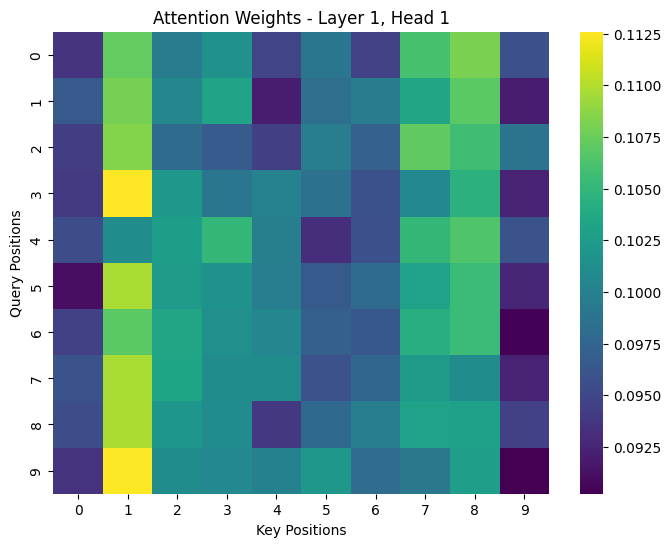

In [7]:
# Assume we have attention weights from the previous example
plot_attention_weights(attn_weights, layer=0, head=0)